In [ ]:
# # EasyEnsemble 通过对原始的数据集进行随机下采样实现对数据集进行集成.
# EasyEnsemble 有两个很重要的参数: (i) n_subsets 控制的是子集的个数 and (ii) replacement 决定是有放回还是无放回的随机采样.
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import EasyEnsemble
ee = EasyEnsemble(random_state=0, n_subsets=10)
X_resampled, y_resampled = ee.fit_sample(X, y)
sorted(Counter(y_resampled[0]).items())
# [(0, 163), (1, 163), (2, 163)]


In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
#import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet import 
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import seaborn as sns

gpus = tf.config.list_physical_devices("GPU")
 
if gpus:
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

#-----------------------------------------------------------------------------------------------------------
norm_size = 100
#datapath = 'C:\\Users\\HT\\Desktop\\论文\\Back\\data\\train'
EPOCHS = 30
INIT_LR = 1e-3
#labelList = []
#dicClass = {'cat': 0, 'dog': 1}
classnum = 2
batch_size =1600
#-------------------------------------------------------------------------------------------------------------
# 1: 加载数据文件，查看数据信息
df = pd.read_csv('train.csv')
df.head() # broadband 即可：0-离开，1-留存
df_test = pd.read_csv('test.csv')
df = df.sample(frac=0.7, replace=False, weights=None, random_state=None, axis=0)
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
# LabelEncoder
for col in tqdm_notebook(df.columns):
    if df[col].dtype == "object":
        encoder = LabelEncoder()
        encoder.fit(list(df[col].values) + list(df_test[col].values))
        df[col] = encoder.transform(list(df[col].values))
        df_test[col] = encoder.transform(list(df_test[col].values))
        
df = df.reset_index() # 重置索引
df_test = df_test.reset_index()
def clean_top_cols(df):
    new_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 1]
    return new_cols
df_cols = clean_top_cols(df)
df_test_clos = clean_top_cols(df_test)
cols_to_drop = list(set(df_cols + df_test_clos))
if 'bad_good' in cols_to_drop : # 查看标签列是否在其中
    cols_to_drop.remove('bad_good') # 删除标签列
#print("原始的train shape : ", df)
df = df.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)
#print("清理后的train shape : ", df.shape)

y = df['bad_good'] # 标签
X1 = df.iloc[:, 1:-1] # 客户 id 没有用，故丢弃 cust_id



C:\Users\HT\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\HT\AppData\Local\Temp/ipykernel_11696/3283838803.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(df.columns):


  0%|          | 0/627 [00:00<?, ?it/s]

In [2]:
print(X1.shape)
X1 = X1.drop('guozhai_flag',axis=1)
print(X1.shape)

(199700, 626)
(199700, 625)


C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


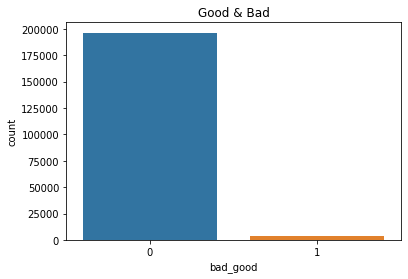

In [3]:
sns.countplot('bad_good', data=X1)
plt.title("Good & Bad")
plt.show()

In [5]:
#M = np.expand_dims(X1, axis = 2)
X = X1[0:100000]
X = np.array(X1, dtype="int")
#print(X1.shape)



In [6]:
X.resize(100000,25,25,3)

In [21]:
print(X.shape)

(100000, 25, 25, 3)


In [24]:
print(y.shape)
#y = y.drop(9)
#print(y.shape)

(100000,)


In [7]:
labelList = []
y = y [0:100000]
labelList = np.array(y,dtype="int")

#X = tf.cast(X, tf.float32)
print(y)
#y.resize(2009,142)
#y = np.expand_dims(y, axis=2)
#print(y.shape)

imageArr = X

0        0
1        0
2        1
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: bad_good, Length: 100000, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split

trainX, valX, trainY, valY = train_test_split(imageArr, labelList, test_size=0.2, random_state=42)

#----------------------------------------------------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(featurewise_center=True,
                featurewise_std_normalization=True,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True)
val_datagen = ImageDataGenerator() # 验证集不做图片增强
train_generator = train_datagen.flow(trainX, trainY, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(valX, valY, batch_size=batch_size, shuffle=True)
checkpointer = ModelCheckpoint(filepath='weights_best_Reset50_model.hdf5',
               monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
 
reduce = ReduceLROnPlateau(monitor='val_accuracy', patience=10,
               verbose=1,
               factor=0.5,
               min_lr=1e-6)
 
model = ResNet50(weights=None, classes=classnum)
#   inputs = input((25,25,1)) 
    #it seems you're using (3,None,None) instead.    
    #choose based on your "data_format", which by default is channels_last 

#outputs = Lambda(mean_subtract,output_shape=not_necessary_with_tensorflow)(inputs)
optimizer = Adam(learning_rate=INIT_LR)
#model= load_model("my_model_resnet.h5")
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit_generator(train_generator,
              steps_per_epoch=trainX.shape[0] / batch_size,
              validation_data=val_generator,
              epochs=EPOCHS,
              validation_steps=valX.shape[0] / batch_size,
              callbacks=[checkpointer, reduce],
              verbose=1, shuffle=True)
model.save('my_model_resnet.h5')

print(history)
 
loss_trend_graph_path = r"WW_loss.jpg"
acc_trend_graph_path = r"WW_acc.jpg"
import matplotlib.pyplot as plt
 
print("Now,we start drawing the loss and acc trends graph...")
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.savefig(acc_trend_graph_path)
plt.close(1)
# summarize history for loss
fig = plt.figure(2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.savefig(loss_trend_graph_path)
plt.close(2)
print("We are done, everything seems OK...")
# #windows系统设置10关机
#os.system("shutdown -s -t 10")

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
50/50 [==============================] - 4617s 92s/step - loss: 0.4514 - accuracy: 0.9302 - val_loss: 0.9193 - val_accuracy: 0.1854

Epoch 00001: val_accuracy improved from -inf to 0.18540, saving model to weights_best_Reset50_model.hdf5


C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
50/50 [==============================] - 4577s 92s/step - loss: 0.1765 - accuracy: 0.9586 - val_loss: 0.1999 - val_accuracy: 0.9579

Epoch 00002: val_accuracy improved from 0.18540 to 0.95795, saving model to weights_best_Reset50_model.hdf5
Epoch 3/30
50/50 [==============================] - 4581s 92s/step - loss: 0.1778 - accuracy: 0.9584 - val_loss: 0.1762 - val_accuracy: 0.9579

Epoch 00003: val_accuracy did not improve from 0.95795
Epoch 4/30
50/50 [==============================] - 4542s 91s/step - loss: 0.1830 - accuracy: 0.9584 - val_loss: 0.1747 - val_accuracy: 0.9579

Epoch 00004: val_accuracy did not improve from 0.95795
Epoch 5/30
50/50 [==============================] - 4535s 91s/step - loss: 0.1801 - accuracy: 0.9585 - val_loss: 0.1749 - val_accuracy: 0.9579

Epoch 00005: val_accuracy did not improve from 0.95795
Epoch 6/30
50/50 [==============================] - 4555s 91s/step - loss: 0.1826 - accuracy: 0.9585 - val_loss: 0.1743 - val_accuracy: 0.9579

Epoch 0

In [9]:
import matplotlib.pyplot as plt
 
print("Now,we start drawing the loss and acc trends graph...")
# summarize history for accuracy
fig = plt.figure(1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.savefig(acc_trend_graph_path)
plt.close(1)
# summarize history for loss
fig = plt.figure(2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.savefig(loss_trend_graph_path)
plt.close(2)
print("We are done, everything seems OK...")

Now,we start drawing the loss and acc trends graph...
We are done, everything seems OK...


In [12]:
print(df_test.shape)
print(trainX.shape)

(189766, 25, 25, 3)
(80000, 25, 25, 3)


In [11]:
df_test = df_test.drop(['CUST_ID'], axis=1)
df_test = df_test.drop('guozhai_flag',axis=1)
df_test = np.array(df_test, dtype="int")
df_test.resize(189766,25,25,3)

In [13]:
df_test_pred = model.predict(df_test)

ValueError: in user code:

    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer resnet50: expected shape=(None, 224, 224, 3), found shape=(None, 25, 25, 3)
